![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

#### Análisis descriptivo

No parece haber mucha diferencia entre la cantidad de bicicletas rentadas en día laboral o en fin de semana o festivo. En la siguiente tabla se presentan métricas adicionales. Se destaca lo siguiente:
- En promedio, se rentan 5 bicicletas más en día laboral que en fin de semana o festivo.
- De acuerdo con los percentiles, la distibución de la cantidad de bicicletas rentadas es sesgada a la derecha tanto para día laboral y fin de semana o festivo.
- En todos los días de la muestra, por lo menos se rentó 1 bicicleta.

In [5]:
bikes.groupby('workingday').total.describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,3474.0,188.506621,173.724015,1.0,44.0,128.0,304.0,783.0
1,7412.0,193.011873,184.513659,1.0,41.0,151.0,277.0,977.0


workingday
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: total, dtype: object

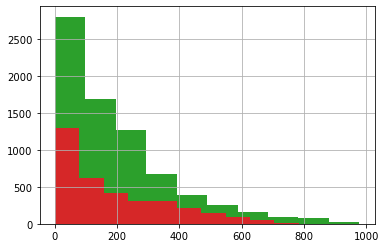

In [6]:
bikes.groupby(bikes['workingday'] == 1).total.hist()
bikes.groupby(bikes['workingday'] == 0).total.hist()

In [7]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

#### Análisis descriptivo

Es claro que la cantidad de bicicletas rentadas cambia según la franja horaria del día, presentando:
- Un periodo de baja demanda entre las 23 horas y las 6 horas del siguiente día.
- Un periodo de alta demanda entre las 7 horas y las 22 horas.
- La franja de mayor demanda ocurre entre las 17 y 18 horas.

In [8]:
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

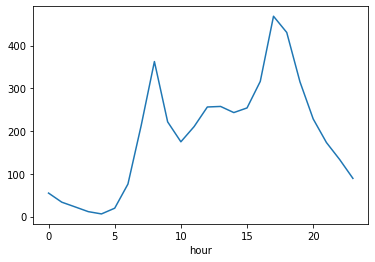

In [9]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

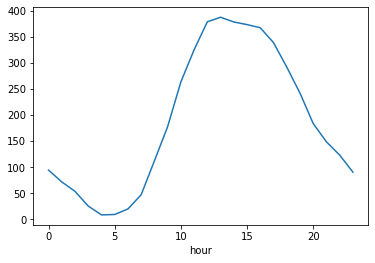

In [10]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
bikes[bikes['workingday'] == 0].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

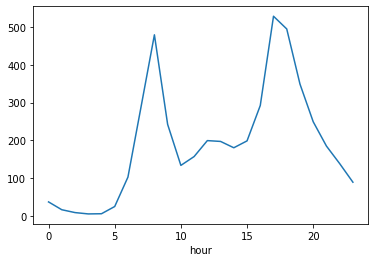

In [11]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes[bikes['workingday'] == 1].groupby('hour').total.mean().plot()

#### Análisis descriptivo

El patrón de comportamiento horario de renta de bicicletas cambia drásticamente entre un día laboral y un fin de semana o día festivo. En día laboral, se identifican dos periodos de alta demanda, en la mañana y en la tarde, posiblemente asociado a la hora de ingreso y salida laboral. Por otra parte, los fines de semana y días festivos solo presentan un periodo de alta demanda durante el día que tiene un máximo en la franja de las 13 horas.

En ambos patrones, el comportamiento entre las 23 horas y las 6 horas del siguiente día son similares, presentando baja demanda de alquiler de bicicletas.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [12]:
# Celda 3

# Importar librerías
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Definición de datos para entrenamiento y evaluación
X = bikes[["hour", "workingday"]]
y = bikes[["total"]]

# Ajuste de modelo Regresión Lineal
LinReg= LinearRegression()
LinReg.fit(X, y)
prediccion = LinReg.predict(X)

# Resultados del modelo
print("Coeficientes del modelo de regresión lineal: ", LinReg.coef_)    #Coeficientes
# R^2
print ("Coeficiente de determinación R^2 del modelo: ", LinReg.score(X, y, sample_weight=None))
# MSE
print ("MSE del modelo: ", mean_squared_error(y,prediccion))

Coeficientes del modelo de regresión lineal:  [[10.49206282  4.07248627]]
Coeficiente de determinación R^2 del modelo:  0.16059115011434855
MSE del modelo:  27541.255252498402


#### Análisis
El coeficiente de determinación R^2 del modelo es muy bajo (0.16) por lo cual, la Regresión Lineal no es un modelo que pueda representar la cantidad de bicicletas rentadas en función de la hora y del tipo de día. Esto es un resultado acorde con el comportamiento no lineal observado en las gráficas obtenidas en el _Punto 3._

Los coeficientes del modelos son 10,49 para _hour_ y 4,07 para _workingday._

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [13]:
# Celda 4

## Funciones de apoyo

# Importar librería para calcular MSE
from sklearn.metrics import mean_squared_error

## Definición de funciones 

# Cálculo del MSE con respecto al promedio de cada hoja
def calcular_mse(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    y_l_pred = [y_l.mean()[0] for i in range(len(y_l))]
    y_r_pred = [y_r.mean()[0] for i in range(len(y_r))]
    
    mse_valor = mean_squared_error(y_l,y_l_pred) + mean_squared_error(y_r,y_r_pred)
    return mse_valor

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 1000000000]  # j, split, MSE
    
    # Para todas las varibles 
    
    j=0    
    splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
    splits = np.unique(splits)[1:]
        
    # Para cada partición
    for split in splits:
        MSE = calcular_mse(X.iloc[:, j], y, split)
                        
        if MSE < best_split[2]:
            best_split = [j, split, MSE]
    
    return best_split

#### Desarrollo manual del árbol
num_pct = 12   # Definición de percentiles para la variable "hour"

## Primer nivel -> Partición por "workingday" 0 en rama izquierda y 1 en rama derecha

# Partición en nodo inicial sobre la variable "workingday"
filtro_izq = X["workingday"] == 0
X_workingday_0_N1 = X.loc[filtro_izq]
y_workingday_0_N1 = y.loc[filtro_izq]

# Partición en nodo inicial sobre la variable "workingday"
filtro_izq = X["workingday"] == 1
X_workingday_1_N1 = X.loc[filtro_izq]
y_workingday_1_N1 = y.loc[filtro_izq]


### Desarrollo del árbol para workingday = 0
## Segundo nivel

# Mejor partición izquierda primer nivel de workingday = 0
mejor_particion = best_split(X_workingday_0_N1, y_workingday_0_N1, num_pct)
print('Mejor partición izquierda segundo nivel de workingday = 0. Feature: "',  X.iloc[:,mejor_particion[0]].name, '" ; partición en: ',
     mejor_particion[1], '; MSE(izq+der): ', mejor_particion[2])

filtro_izq = X_workingday_0_N1["hour"] <= 9
X_workingday_0_N2_izq = X_workingday_0_N1.loc[filtro_izq]
y_workingday_0_N2_izq = y_workingday_0_N1.loc[filtro_izq]

filtro_der = X_workingday_0_N1["hour"] > 9
X_workingday_0_N2_der = X_workingday_0_N1.loc[filtro_der]
y_workingday_0_N2_der = y_workingday_0_N1.loc[filtro_der]

## Tercer nivel

# Mejor partición izquierda segundo nivel de workingday = 0
mejor_particion = best_split(X_workingday_0_N2_der, y_workingday_0_N2_der, num_pct)
print('Mejor partición izquierda tercer nivel de workingday = 0. Feature: "',  X.iloc[:,mejor_particion[0]].name, '" ; partición en: ',
     mejor_particion[1], '; MSE(izq+der): ', mejor_particion[2], '\n')

filtro_izq = X_workingday_0_N1["hour"] <= 22
X_workingday_0_N3_izq = X_workingday_0_N2_der.loc[filtro_izq]
y_workingday_0_N3_izq = y_workingday_0_N2_der.loc[filtro_izq]

filtro_der = X_workingday_0_N1["hour"] > 22
X_workingday_0_N3_der = X_workingday_0_N2_der.loc[filtro_der]
y_workingday_0_N3_der = y_workingday_0_N2_der.loc[filtro_der]

### Desarrollo del árbol para workingday = 1
## Segundo nivel

# Mejor partición izquierda primer nivel de workingday = 1
mejor_particion = best_split(X_workingday_1_N1, y_workingday_1_N1, num_pct)
print('Mejor partición izquierda segundo nivel de workingday = 1. Feature: "',  X.iloc[:,mejor_particion[0]].name, '" ; partición en: ',
     mejor_particion[1], '; MSE(izq+der): ', mejor_particion[2])

filtro_izq = X_workingday_1_N1["hour"] <= 5
X_workingday_1_N2_izq = X_workingday_1_N1.loc[filtro_izq]
y_workingday_1_N2_izq = y_workingday_1_N1.loc[filtro_izq]

filtro_der = X_workingday_1_N1["hour"] > 5
X_workingday_1_N2_der = X_workingday_1_N1.loc[filtro_der]
y_workingday_1_N2_der = y_workingday_1_N1.loc[filtro_der]

## Tercer nivel

# Mejor partición izquierda segundo nivel de workingday = 0
mejor_particion = best_split(X_workingday_1_N2_der, y_workingday_1_N2_der, num_pct)
print('Mejor partición izquierda tercer nivel de workingday = 1. Feature: "',  X.iloc[:,mejor_particion[0]].name, '" ; partición en: ',
     mejor_particion[1], '; MSE(izq+der): ', mejor_particion[2], '\n')

filtro_izq = X_workingday_1_N1["hour"] <= 7
X_workingday_1_N3_izq = X_workingday_1_N2_der.loc[filtro_izq]
y_workingday_1_N3_izq = y_workingday_1_N2_der.loc[filtro_izq]

filtro_der = X_workingday_1_N1["hour"] > 7
X_workingday_1_N3_der = X_workingday_1_N2_der.loc[filtro_der]
y_workingday_1_N3_der = y_workingday_1_N2_der.loc[filtro_der]

## Descripción del valor predicho en cada hoja del árbol de decición con 6 nodos terminales

print('Descripción del modelo obtenido de manera manual \n')
print('Para workingday = 0 & hour <= 9, la predicción es: ', y_workingday_0_N2_izq.mean()[0])
print('Para workingday = 0 & hour > 9 & hour <= 22, la predicción es: ', y_workingday_0_N3_izq.mean()[0])
print('Para workingday = 0 & hour > 22, la predicción es: ', y_workingday_0_N3_der.mean()[0])
print('Para workingday = 1 & hour <= 5, la predicción es: ', y_workingday_1_N2_izq.mean()[0])
print('Para workingday = 1 & hour > 5 & hour <= 7, la predicción es: ', y_workingday_1_N3_izq.mean()[0])
print('Para workingday = 1 & hour > 7, la predicción es: ', y_workingday_1_N3_der.mean()[0])
print('     Se podría continuar desarrollando el árbol en esta última rama')


Mejor partición izquierda segundo nivel de workingday = 0. Feature: " hour " ; partición en:  9.0 ; MSE(izq+der):  30814.886618612472
Mejor partición izquierda tercer nivel de workingday = 0. Feature: " hour " ; partición en:  22.0 ; MSE(izq+der):  31803.752259215224 

Mejor partición izquierda segundo nivel de workingday = 1. Feature: " hour " ; partición en:  5.0 ; MSE(izq+der):  32758.088586659003
Mejor partición izquierda tercer nivel de workingday = 1. Feature: " hour " ; partición en:  7.0 ; MSE(izq+der):  33965.41699806182 

Descripción del modelo obtenido de manera manual 

Para workingday = 0 & hour <= 9, la predicción es:  62.25069252077562
Para workingday = 0 & hour > 9 & hour <= 22, la predicción es:  292.7554376657825
Para workingday = 0 & hour > 22, la predicción es:  90.60689655172413
Para workingday = 1 & hour <= 5, la predicción es:  16.217582417582417
Para workingday = 1 & hour > 5 & hour <= 7, la predicción es:  196.63387096774193
Para workingday = 1 & hour > 7, la p

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

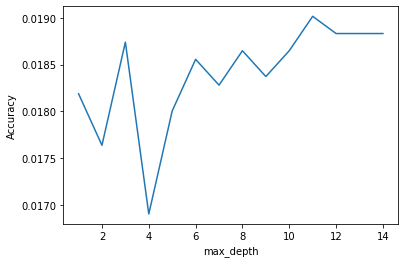

El MSE del modelo es: 19651.87828403454


,feature,importance
1,workingday,0.235602
0,hour,0.764398


In [14]:
# Celda 5

# Importar Matplotlib
import matplotlib.pyplot as plt

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 15)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clfTree = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clfTree, X, y, cv=10, scoring='accuracy').mean())

# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

# max_depth=11 fue el mejor, se ajusta un árbol usando este valor 
clfTree = DecisionTreeClassifier(max_depth=11, random_state=1)
clfTree.fit(X, y)
prediccion = clfTree.predict(X)

print('El MSE del modelo es:', mean_squared_error(y,prediccion))
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':X.columns, 'importance':clfTree.feature_importances_}).sort_values('importance')

#### Análisis

Comparando el MSE de los modelos de regresión lineal (MSE_RL = 27541.26) y de árbol de decisión (MSE_AD = 19651.8), se encuentra que este último tiene mejor desempeño. Este resultado está asociado a:

- La flexibilidad que tienen los árboles de decisión para segmentar los valores de los predictores. En el ejercicio del _Punto 4,_ se identificó que es posible desarrollar más niveles en el árbol , lo cual se evidencia en el _Punto 5_ donde el mejor resultado se encontró con un árbol de 11 niveles.
- En las gráficas desarrolladas en el _Punto 2_ se identificó un comportamiento no lineal en la variable de salida, por lo cual se identifica que un modelo de Regresión Lineal no tendría buen desempeño.
- En el modelo, el predictor 'hour' tiene mayor importancia que 'workingday'.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [15]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [16]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [17]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [18]:
# Celda 6
# Importación de modelos y métricas de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
# Importar Matplotlib
import matplotlib.pyplot as plt

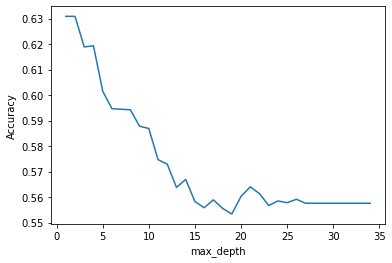

- Modelo de Árbol de decisión
El modelo con mejor Accuracy se obtiene con un árbol de profundidad igual a 2
El F1 Score del modelo de Árbol de decisión es:  0.6448598130841121
El Accuracy del modelo de Árbol de decisión es:  0.6453333333333333 

Los predictores relevantes del modelo son kw_avg_avg y kw_max_avg (ver siguiente tabla) 

                feature  importance
26           kw_avg_avg    0.900096
25           kw_max_avg    0.099904
0             timedelta    0.000000
31   weekday_is_tuesday    0.000000
33  weekday_is_thursday    0.000000


- Modelo de Regresión logística
El F1 Score del modelo de Regresión logística es:  0.6131687242798353
El Accuracy del modelo de Regresión logística es:  0.624


- Modelo de Regresión logística con solo predictores relevantes identificados en modelo Árbol de decisión
El F1 Score del modelo de Regresión logística con predictores relevantes es:  0.6705150976909415
El Accuracy del modelo de Regresión logística con predictores relevantes es:  0.50

In [19]:
#### Modelo Árbol de decisión

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 35)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clfTree = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clfTree, X_train, y_train, cv=10, scoring='accuracy').mean())

# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

# max_depth=2 fue el mejor, se ajusta un árbol usando este valor 
clfTree = DecisionTreeClassifier(max_depth=2, random_state=1)
clfTree.fit(X_train, y_train)
prediccionTree = clfTree.predict(X_test)

print('- Modelo de Árbol de decisión')
print('El modelo con mejor Accuracy se obtiene con un árbol de profundidad igual a 2')
print('El F1 Score del modelo de Árbol de decisión es: ', f1_score(y_test, prediccionTree))
print('El Accuracy del modelo de Árbol de decisión es: ', accuracy_score(y_test, prediccionTree), '\n')
print ('Los predictores relevantes del modelo son kw_avg_avg y kw_max_avg (ver siguiente tabla) \n')

# Uso de la función .feature_importances_ para obtener la importancia de cada variable
print(pd.DataFrame({'feature':X_train.columns, 'importance':clfTree.feature_importances_}).sort_values('importance', ascending=False).head())


#### Modelo de regresión logística

clfRegLog= LogisticRegression(random_state=0,max_iter=10000)
clfRegLog.fit(X_train, y_train)
prediccionesRegLog=clfRegLog.predict(X_test)

print('\n')
print('- Modelo de Regresión logística')
print('El F1 Score del modelo de Regresión logística es: ', f1_score(y_test, prediccionesRegLog))
print('El Accuracy del modelo de Regresión logística es: ', accuracy_score(y_test, prediccionesRegLog))

clfRegLog.fit(X_train[["kw_avg_avg", "kw_max_avg"]], y_train)
prediccionesRegLog=clfRegLog.predict(X_test[["kw_avg_avg", "kw_max_avg"]])

print('\n')
print('- Modelo de Regresión logística con solo predictores relevantes identificados en modelo Árbol de decisión')
print('El F1 Score del modelo de Regresión logística con predictores relevantes es: ', f1_score(y_test, prediccionesRegLog))
print('El Accuracy del modelo de Regresión logística con predictores relevantes es: ', accuracy_score(y_test, prediccionesRegLog))


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [20]:
# Celda 7

# Importar librerías
from sklearn.ensemble import BaggingClassifier

# Uso de BaggingRegressor con modelo Árbol de decisión

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=1, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred_arbol_1a = clf.predict(X_test)

print('Resultados del Punto 7 \n')
print('- Modelo Árbol de decisión')
print('El F1 Score del modelo Árbol de decisión es: ', f1_score(y_test, y_pred_arbol_1a))
print('El Accuracy del modelo Árbol de decisión es: ', accuracy_score(y_test, y_pred_arbol_1a), '\n')


# Uso de BaggingRegressor con modelo Árbol de decisión de dos niveles

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=1, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred_arbol_2a = clf.predict(X_test)

print('- Modelo Árbol de decisión de dos niveles')
print('El F1 Score del modelo Árbol de decisión de dos niveles es: ', f1_score(y_test, y_pred_arbol_2a))
print('El Accuracy del modelo Árbol de decisión de dos niveles es: ', accuracy_score(y_test, y_pred_arbol_2a), '\n')


# Uso de BaggingRegressor con Modelo Regresión logística

clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=1, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred_RegLog_a = clf.predict(X_test)

print('- Modelo Regresión logística')
print('El F1 Score del modelo de Regresión logística es: ', f1_score(y_test, y_pred_RegLog_a))
print('El Accuracy del modelo de Regresión logística es: ', accuracy_score(y_test, y_pred_RegLog_a), '\n')



Resultados del Punto 7 

- Modelo Árbol de decisión
El F1 Score del modelo Árbol de decisión es:  0.6626262626262627
El Accuracy del modelo Árbol de decisión es:  0.666 

- Modelo Árbol de decisión de dos niveles
El F1 Score del modelo Árbol de decisión de dos niveles es:  0.6486120514556534
El Accuracy del modelo Árbol de decisión de dos niveles es:  0.654 

- Modelo Regresión logística
El F1 Score del modelo de Regresión logística es:  0.6092896174863389
El Accuracy del modelo de Regresión logística es:  0.6186666666666667 



### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [21]:
# Celda 8

# Importar librerías
from sklearn import metrics

# Uso de BaggingRegressor con modelo Árbol de decisión

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=1, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred_arbol_1b = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

print('Resultados del Punto 8 \n')
print('- Modelo Árbol de decisión')
print('El F1 Score del modelo Árbol de decisión es: ', f1_score(y_test, y_pred_arbol_1b))
print('El Accuracy del modelo Árbol de decisión es: ', accuracy_score(y_test, y_pred_arbol_1b), '\n')


# Uso de BaggingRegressor con modelo Árbol de decisión de dos niveles

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=1, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred_arbol_2b = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

print('- Modelo Árbol de decisión de dos niveles')
print('El F1 Score del modelo Árbol de decisión de dos niveles es: ', f1_score(y_test, y_pred_arbol_2b))
print('El Accuracy del modelo Árbol de decisión de dos niveles es: ', accuracy_score(y_test, y_pred_arbol_2b), '\n')


# Uso de BaggingRegressor con Modelo Regresión logística

clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=1, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred_RegLog_b = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

print('- Modelo Regresión logística')
print('El F1 Score del modelo de Regresión logística es: ', f1_score(y_test, y_pred_RegLog_b))
print('El Accuracy del modelo de Regresión logística es: ', accuracy_score(y_test, y_pred_RegLog_b), '\n')

Resultados del Punto 8 

- Modelo Árbol de decisión
El F1 Score del modelo Árbol de decisión es:  0.6640053226879573
El Accuracy del modelo Árbol de decisión es:  0.6633333333333333 

- Modelo Árbol de decisión de dos niveles
El F1 Score del modelo Árbol de decisión de dos niveles es:  0.6416893732970027
El Accuracy del modelo Árbol de decisión de dos niveles es:  0.6493333333333333 

- Modelo Regresión logística
El F1 Score del modelo de Regresión logística es:  0.6145479265805575
El Accuracy del modelo de Regresión logística es:  0.622 



### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

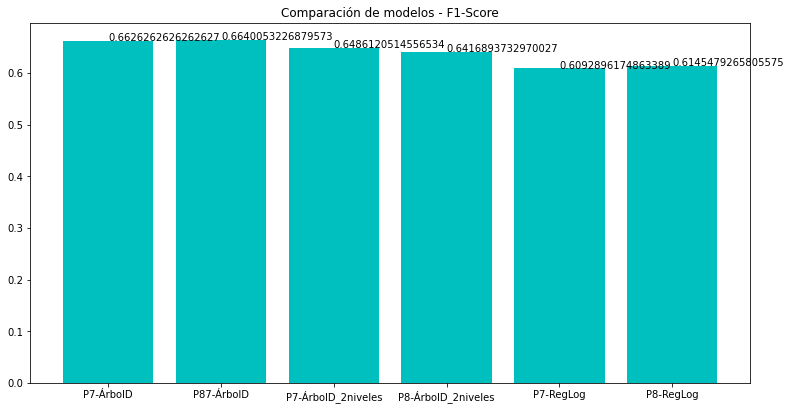

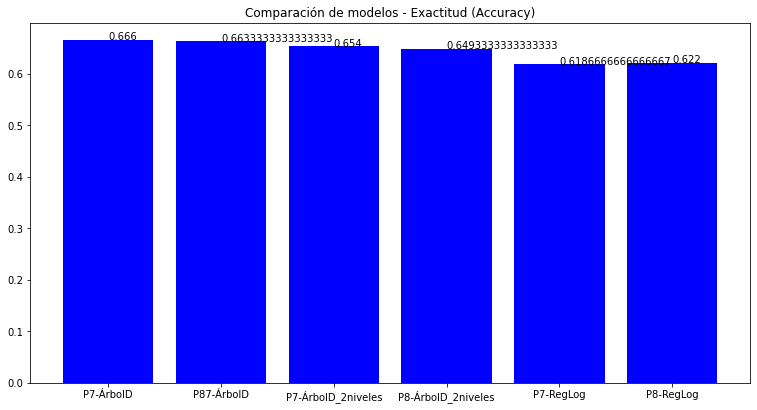

In [22]:
# Celda 9 (ver análisis en la última celda)

### Gráfica para comparar F1-Score

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos - F1-Score")
ejeX = ['P7-ÁrbolD','P87-ÁrbolD','P7-ÁrbolD_2niveles','P8-ÁrbolD_2niveles','P7-RegLog','P8-RegLog']
ejeY = [f1_score(y_test, y_pred_arbol_1a), f1_score(y_test, y_pred_arbol_1b), f1_score(y_test, y_pred_arbol_2a),
        f1_score(y_test, y_pred_arbol_2b), f1_score(y_test, y_pred_RegLog_a), f1_score(y_test, y_pred_RegLog_b),]

ax.bar(ejeX,ejeY, color="c")
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

### Gráfica para comparar exactitud 

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos - Exactitud (Accuracy)")
ejeX = ['P7-ÁrbolD','P87-ÁrbolD','P7-ÁrbolD_2niveles','P8-ÁrbolD_2niveles','P7-RegLog','P8-RegLog']
ejeY = [accuracy_score(y_test, y_pred_arbol_1a), accuracy_score(y_test, y_pred_arbol_1b),
        accuracy_score(y_test, y_pred_arbol_2a), accuracy_score(y_test, y_pred_arbol_2b),
        accuracy_score(y_test, y_pred_RegLog_a), accuracy_score(y_test, y_pred_RegLog_b)]
ax.bar(ejeX,ejeY, color="b")
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()



#### Análisis de resultados

- De acuerdo con el resultado de las métricas F1 y Accuracy, el modelo de Árbol de decisión sin límite de profundidad tiene mejor desempeño que los demás modelos desarrollados en los puntos 7 y 8. Este modelo tiene la desventaja de requerir mayor tiempo de procesamiento computacional. No se aprecia una diferencia relevante entre el modelo con votación mayoritaria y el modelo con votación ponderada.
- A su vez, el segundo mejor modelo, es el Árbol de decisión con dos niveles de profundidad. Su desempeño es ligeramente inferior que el modelo sin límite en la profundidad, sin embargo, el tiempo de procesamiento computacional es menor. Esta ventaja se podría aprovechar si se llega a requerir que el modelo maneje un volumen mucho mayor de datos. No se aprecia una diferencia relevante entre el modelo con votación mayoritaria y el modelo con votación ponderada.
- Por último, el modelo de Regresión logística obtuvo el menor desempeño de los modelos analizados. Sus métricas F1 y Accuracy están alrededor de 0.05 puntos por debajo del mejor modelo. Se destaca que el modelo con votación ponderada tuvo un desempeño ligeramente mejor frente al modelo con votación mayoritaria.
